In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import bloscpack as bp

import sys
import os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from annotation_utilities import *
from metadata import *

import time

import matplotlib.pyplot as plt
%matplotlib inline

from vis3d_utilities import *

Setting environment for Local Macbook Pro


In [4]:
brain_spec = dict(name='MD589', 
                  resolution='10.0um', 
                  vol_type='annotationAsScore', 
                  prep_id=None,
                  detector_id=None,
                  structure=None)

stack = brain_spec['name']

In [5]:
volume_resolution_um = 10.

# Compute shell mesh from thumbnail tissue masks

In [126]:
from skimage.morphology import binary_closing, disk, remove_small_holes

fatten_masks = True

In [153]:
contours_xyz_wrt_wholebrain_volResol = []

for sec in metadata_cache['valid_sections'][stack]:

    mask_tbResol = DataManager.load_thumbnail_mask_v3(stack, prep_id=1, section=sec)
    
    if fatten_masks:    
        mask_tbResol = binary_closing(mask_tbResol, selem=disk(10))
        mask_tbResol = remove_small_holes(mask_tbResol, min_size=10000)
    
    contours_wrt_wholebrain_tbResol = find_contour_points(mask_tbResol, sample_every=3)[1]
#     contours_valid = [cnt[(cnt[:,0] >= 1) & (cnt[:,1] >= 1)] for cnt in contours]

    # Select the longest one, in case of multiple contours.
    contour_wrt_wholebrain_tbResol = contours_wrt_wholebrain_tbResol[np.argmax(map(len, contours_wrt_wholebrain_tbResol))]
    contour_xysec_wrt_wholebrain_tbResol = [(x,y,sec) for x,y in contour_wrt_wholebrain_tbResol] 
    contour_xyz_wrt_wholebrain_volResol = convert_frame_and_resolution(contour_xysec_wrt_wholebrain_tbResol, in_wrt='wholebrain', in_resolution='image_image_section',
                                image_resolution='down32', stack=stack,
                                out_wrt='wholebrain', out_resolution='volume',
                                volume_resolution_um=volume_resolution_um)
    
    contours_xyz_wrt_wholebrain_volResol.append(contour_xyz_wrt_wholebrain_volResol)

In [128]:
# mirror_left_to_right = True
mirror_left_to_right = False

In [156]:
all_xyzs_wrt_wholebrain_volResol = np.array([xyz for cnt_xyz in contours_xyz_wrt_wholebrain_volResol for xyz in cnt_xyz])

if mirror_left_to_right:
    mid_z = wrt_wholebrain_volResol = (all_xyzs_wrt_wholebrain_volResol[:,2].min() + all_xyzs_wrt_wholebrain_volResol[:,2].max())/2.
    # all_xyzs_wrt_wholebrain_volResol = np.array([xyz if xyz[2] < mid_z else [x,y,2*mid_z-xyz[2]] for xyz in all_xyzs_wrt_wholebrain_volResol])
    left_xyzs_wrt_wholebrain_volResol = np.array([xyz for xyz in all_xyzs_wrt_wholebrain_volResol if xyz[2] < mid_z])
    all_xyzs_wrt_wholebrain_volResol = np.concatenate([left_xyzs_wrt_wholebrain_volResol, 
                                                      np.c_[left_xyzs_wrt_wholebrain_volResol[:,:2], 2*mid_z - left_xyzs_wrt_wholebrain_volResol[:,2]]])

In [157]:
t = time.time()

shell_sparse_polydata = mesh_to_polydata(vertices=all_xyzs_wrt_wholebrain_volResol, faces=[])
shell_smooth_polydata = poisson_reconstruct_meshlab(polydata=shell_sparse_polydata)

# VTK SurfaceReconstructFilter - likely program bug, distance function is wrong outside the contour.
# polydata = vertices_to_surface(vertices, num_simplify_iter=0, smooth=True)

# VTK marching cube - if applied to points rather than volume, results in separate vertices, not contiguous surface.
# polydata = volume_to_polydata(outerContour_volume, origin=origin, num_simplify_iter=1, smooth=True)

sys.stderr.write('time: %.2f\n' % (time.time() - t) ) # ~ 150s for outerContour; 93s for sp5

mesh_fp = DataManager.get_mesh_filepath_v2(brain_spec=brain_spec, structure='shell')
create_parent_dir_if_not_exists(mesh_fp)
save_mesh_stl(shell_smooth_polydata, mesh_fp)
upload_to_s3(mesh_fp)

mesh_to_polydata: No faces are provided, so skip simplification.


meshlabserver -i /tmp/input.ply -o /tmp/output.stl -s /home/yuncong/Brain/3d/outerContour_poisson_reconstruct.mlx -om vc vn


time: 10.70


aws s3 cp "/home/yuncong/CSHL_meshes/MD594/MD594_10.0um_annotationAsScoreVolume/MD594_10.0um_annotationAsScoreVolume_shell.stl" "s3://mousebrainatlas-data/CSHL_meshes/MD594/MD594_10.0um_annotationAsScoreVolume/MD594_10.0um_annotationAsScoreVolume_shell.stl"


In [158]:
launch_vtk([actor_mesh(shell_smooth_polydata)])

# OLD

In [10]:
outline_volume, outline_volume_bbox_rel2cropped = interpolate_contours_to_volume(contours_xyz=contours_xyz_wrt_wholebrain_volResol, 
                                                                 interpolation_direction='z', fill=False)
print outline_volume_bbox_rel2cropped

[ 147 1773  101  997  184  740]


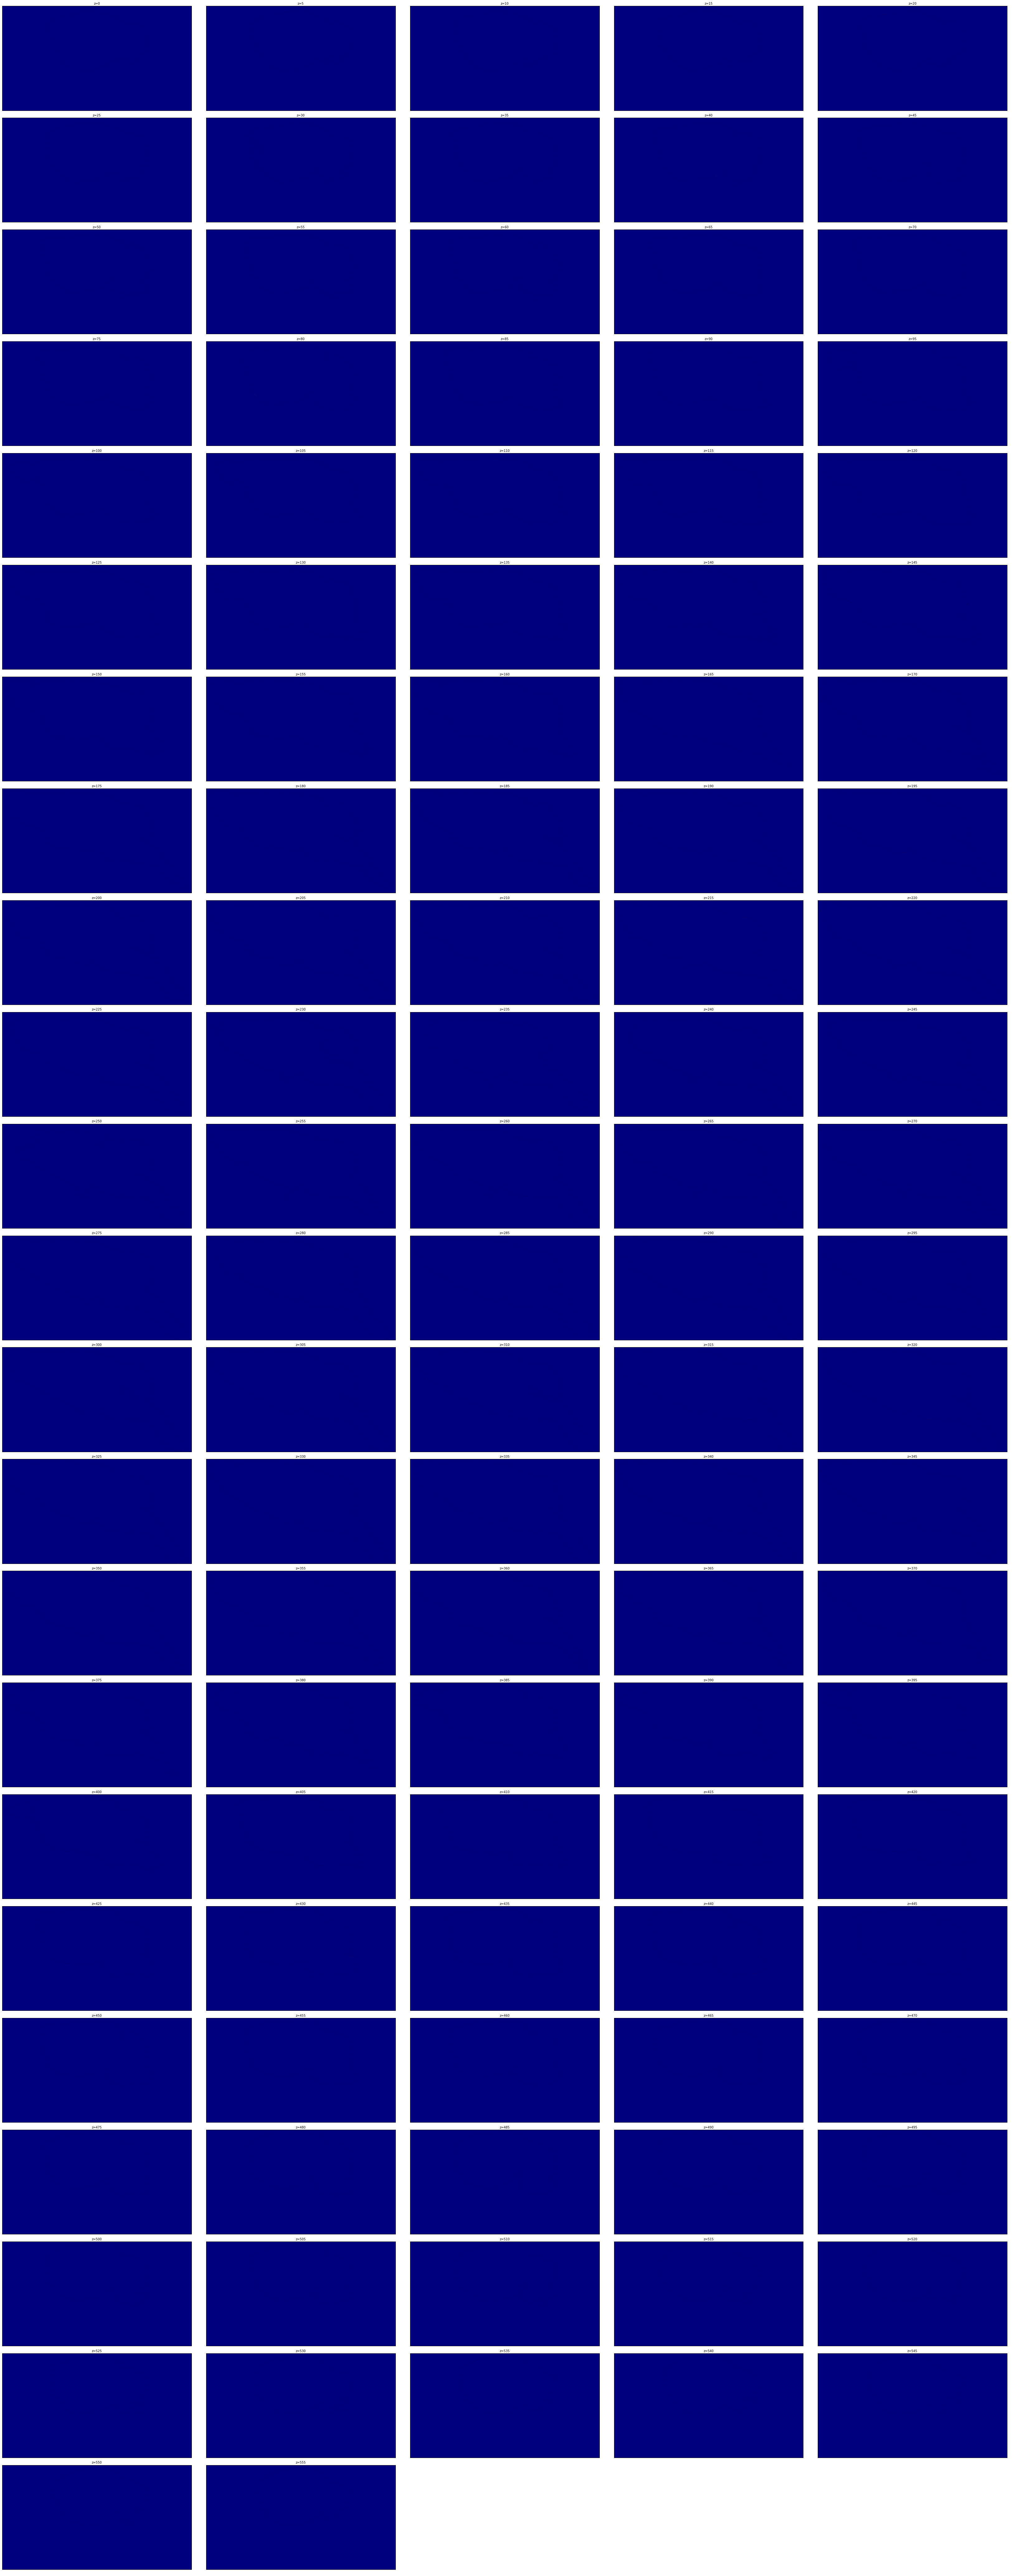

In [12]:
display_volume_sections(outline_volume)

In [ ]:
score_volume_filepath = DataManager.get_original_volume_filepath_v2(brain_spec, structure='shell')

create_parent_dir_if_not_exists(score_volume_filepath)
bp.pack_ndarray_file(outline_volume_score_vol.astype(np.float16), score_volume_filepath)
upload_to_s3(score_volume_filepath)

score_volume_bbox_filepath = DataManager.get_original_volume_bbox_filepath(stack=stack, downscale=32, 
                                                                 volume_type='annotationAsScore',
                                                                        structure='shell', prep_id=2)